### Title

# Flipkart Reviews Sentiment Analysis

### Overview of Problem Statement

Customer reviews play a crucial role in shaping buyer decisions on e-commerce platforms. With thousands of reviews, it becomes challenging for customers to read and interpret sentiment. This project aims to perform sentiment analysis on Flipkart product reviews to classify them into positive and negative categories, helping both customers and businesses gain quick insights.

### Objective

To analyze customer reviews from Flipkart and classify them as Positive or Negative.

To apply different machine learning models to evaluate their performance on sentiment classification.

To identify the best-performing model for future deployment

### Importing necessary libraries

In [1]:
import numpy as np 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import string
import re
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer



from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier


from nltk.corpus import stopwords
from wordcloud import WordCloud



from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
import warnings 
warnings.filterwarnings('ignore')

### Data collection

In [3]:
# Loading the dataset
file_path = 'flipkart_data.csv'
df = pd.read_csv(file_path)

In [4]:
df

,review,rating
0,It was nice produt. I like it's design a lot. ...,5
1,awesome sound....very pretty to see this nd th...,5
2,awesome sound quality. pros 7-8 hrs of battery...,4
3,I think it is such a good product not only as ...,5
4,awesome bass sound quality very good bettary l...,5
...,...,...
9971,GoodREAD MORE,5
9972,Everything is amazimg but the built is very li...,5
9973,GoodREAD MORE,5
9974,Best headphone i have ever used....READ MORE,5


### Data Description

In [5]:
df.shape

(9976, 2)

### EDA

In [6]:
# Get a summary of the dataset
df.info

<bound method DataFrame.info of                                                  review  rating
0     It was nice produt. I like it's design a lot. ...       5
1     awesome sound....very pretty to see this nd th...       5
2     awesome sound quality. pros 7-8 hrs of battery...       4
3     I think it is such a good product not only as ...       5
4     awesome bass sound quality very good bettary l...       5
...                                                 ...     ...
9971                                      GoodREAD MORE       5
9972  Everything is amazimg but the built is very li...       5
9973                                      GoodREAD MORE       5
9974       Best headphone i have ever used....READ MORE       5
9975                                      NiceREAD MORE       5

[9976 rows x 2 columns]>

In [7]:
# Display statistical summary for all columns within the dataFram
df.describe(include='all')

,review,rating
count,9976,9976.000000
unique,7694,NaN
top,GoodREAD MORE,NaN
freq,264,NaN
mean,NaN,4.215417
std,NaN,1.167911
min,NaN,1.000000
25%,NaN,4.000000
50%,NaN,5.000000
75%,NaN,5.000000


In [8]:
df.duplicated().sum()

2108

In [9]:
df.isnull().sum()

review    0
rating    0
dtype: int64

### Preprocessing


In [10]:
# Remove duplicate rows
df = df.drop_duplicates()

In [11]:
df.shape

(7868, 2)

In [12]:
##  Create Sentiment Labels (Positive vs Negative)
# Ratings 4-5 → Positive (1), Ratings 1-2 → Negative (0), Rating 3 → Drop (Neutral)
df = df[df['rating'] != 3]
df['sentiment'] = df['rating'].apply(lambda x: 1 if x > 3 else 0)
df = df[['review', 'sentiment']]


In [13]:
# Text Preprocessing Function with Enhancements
def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = text.translate(str.maketrans('', '', string.punctuation))  # Removing punctuation
    text = re.sub(r"\d+", "", text)  # Removing numerical values
    text = re.sub(r"\s+", " ", text).strip()  # Removing extra spaces
    words = text.split()  # Tokenizing
    words = [word for word in words if word not in stopwords.words('english')]  # Removing stopwords
    return ' '.join(words)

In [14]:
# Applying text preprocessing
# Applying text preprocessing and renaming the column to 'Cleaned_Text'
df['Cleaned_review'] = df['review'].apply(preprocess_text)
df.drop(columns=['review'], inplace=True)

### Visualization

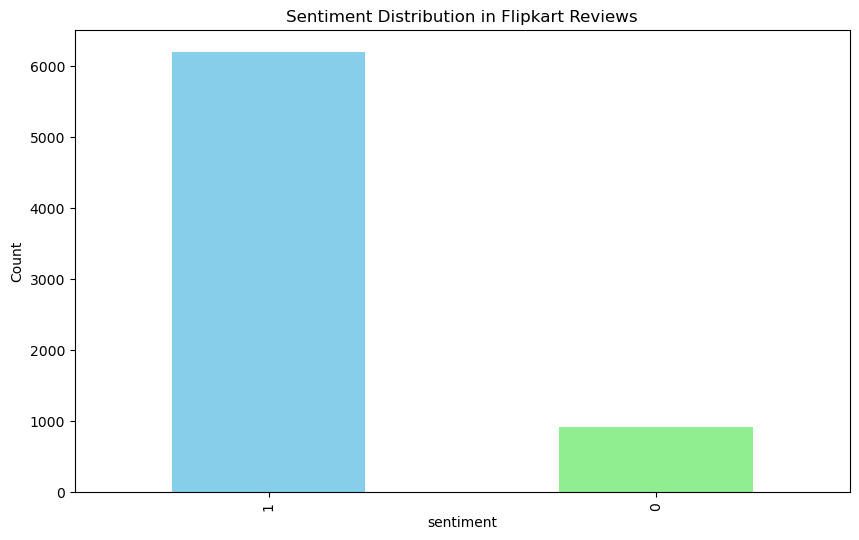

In [15]:
# Visualizing the distribution of sentiments
plt.figure(figsize=(10,6))
df['sentiment'].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen', 'orange', 'red'])
plt.title('Sentiment Distribution in Flipkart Reviews')
plt.xlabel('sentiment')
plt.ylabel('Count')
plt.show()

In [16]:
# Function for Word Cloud Generation
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

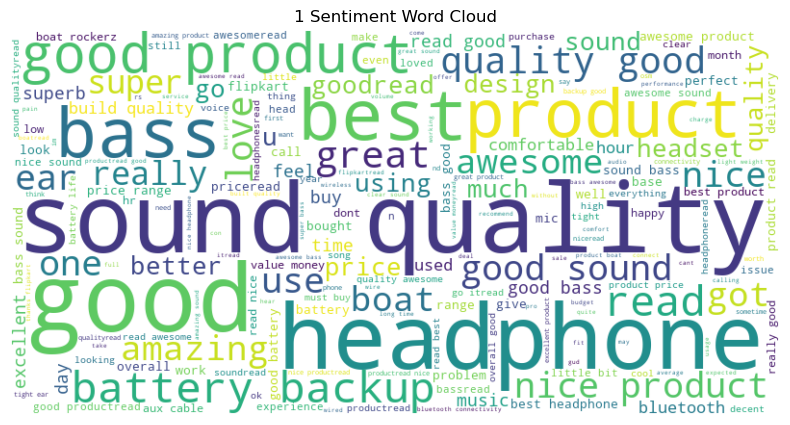

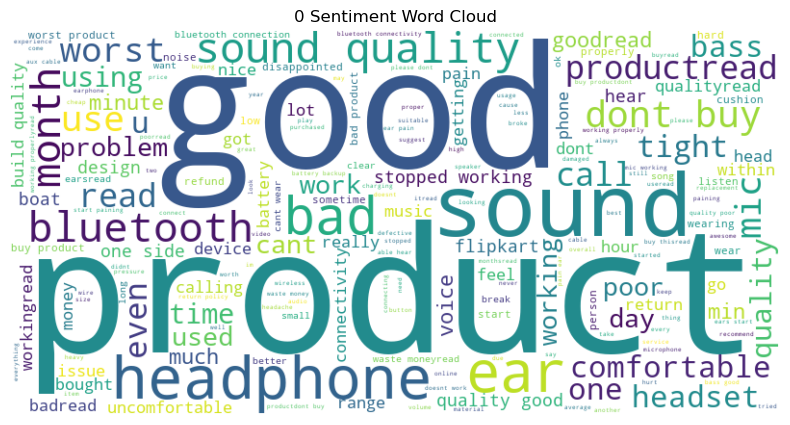

In [17]:
# Generating Word Clouds for each sentiment
for sentiment in df['sentiment'].unique():
    sentiment_text = ' '.join(df[df['sentiment'] == sentiment]['Cleaned_review'])
    generate_wordcloud(sentiment_text, f'{sentiment} Sentiment Word Cloud')

### Data Splitting


In [18]:
X = df['Cleaned_review']
y  = df['sentiment']

### Vectorize the text data using TF-IDF

In [19]:
##  Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Cleaned_review'])
y = df['sentiment']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Building Model

In [21]:
models_dict = {
    'LogisticRegression': LogisticRegression(max_iter=10_000),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'BaggingClassifier': BaggingClassifier(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'XGBClassifier': XGBClassifier()
}


### Find the best Model

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

results = []

for name, model in models_dict.items():
    print(f"\nTraining: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    })

    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))



Training: LogisticRegression
Accuracy: 0.9276
              precision    recall  f1-score   support

           0       0.91      0.40      0.55       161
           1       0.93      1.00      0.96      1261

    accuracy                           0.93      1422
   macro avg       0.92      0.70      0.76      1422
weighted avg       0.93      0.93      0.91      1422


Training: KNeighborsClassifier
Accuracy: 0.8966
              precision    recall  f1-score   support

           0       0.77      0.12      0.21       161
           1       0.90      1.00      0.94      1261

    accuracy                           0.90      1422
   macro avg       0.83      0.56      0.58      1422
weighted avg       0.88      0.90      0.86      1422


Training: DecisionTreeClassifier
Accuracy: 0.8966
              precision    recall  f1-score   support

           0       0.54      0.59      0.56       161
           1       0.95      0.94      0.94      1261

    accuracy                       

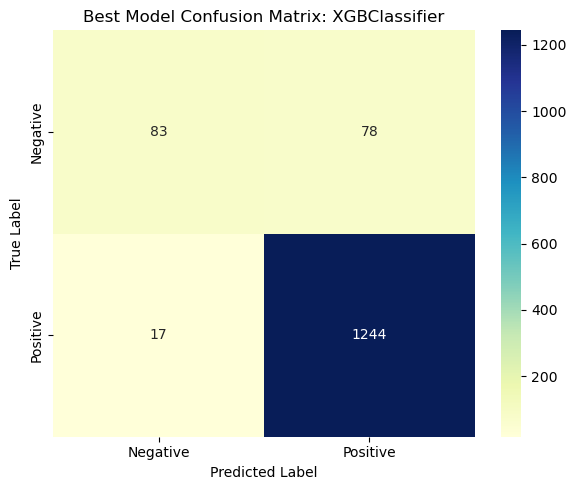

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#  Find the best model (highest accuracy)
best_model_result = max(results, key=lambda x: x['Accuracy'])

#  Extract the confusion matrix and model name
best_model_name = best_model_result['Model']
best_cm = best_model_result['Confusion Matrix']

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.title(f'Best Model Confusion Matrix: {best_model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


### Results

Best Performing Models: Gradient Boosting / XGBoost with highest accuracy and balanced precision-recall.

Observation: Ensemble methods outperform single classifiers due to their ability to handle non-linear text features.

### Conclusion

Sentiment analysis on Flipkart reviews provides a reliable system to classify opinions as positive or negative.

Ensemble classifiers such as Gradient Boosting and XGBoost deliver the best results.

This system can help businesses improve product quality and customer experience by focusing on negative feedback.